### Sample Implementation of Shapelets for RIGHT_ELBOW_ANGLE

In [41]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Havent really used it but eh
from torch.utils.data import DataLoader

## Data Imports
from preprocess.features import *
from preprocess.timeseries import *
from preprocess.utils import *

## Model Imports
from model.shaplet_learner import *
from utils.config import *
from utils.trainer import *
from utils.weight_init import *
from ShapeletLearner.datasets.tsdataset import *


In [15]:
data_path = os.path.join(os.path.abspath(os.path.join(ROOT, "..", ".." )), "P0001_shooting_alt.csv") 
data = pd.read_csv(data_path)

In [16]:
data['RIGHT_ELBOW_ANGLE'] = data.apply(lambda row: angle_finder_shared(A = np.array([row['R_SHOULDER_x'], row['R_SHOULDER_y'], row['R_SHOULDER_z']]), 
                                                                       B = np.array([row['R_ELBOW_x'], row['R_ELBOW_y'], row['R_ELBOW_z']]), 
                                                                       C = np.array([row['R_WRIST_x'], row['R_WRIST_y'], row['R_WRIST_z']]), 
                                                                       D = np.array([row['R_ELBOW_x'], row['R_ELBOW_y'], row['R_ELBOW_z']])), axis=1)
ts_data, labels = DatasetTimeseries(data, 'RIGHT_ELBOW_ANGLE')

In [75]:
import torch
import torch.nn as nn
import torch.nn.functional

import torch

def DTW_calc(ts1, ts2):
    """
    Computes the DTW similarity (for univariate time series) between two time series.
    Handles one input having batch size 1 for broadcasting (shapelet of shape (1, len_shapelet)).
    
    Parameters:
    ts1: Tensor of shape (batch_size1, time_steps1) or (1, time_steps1) (shapelet)
    ts2: Tensor of shape (batch_size2, time_steps2) (time series segment)
    
    Returns:
    dtw_dist: Tensor of shape (batch_size,) containing the DTW distance for each batch.
    """
    # Compute the cost matrix
    cost_mat = cost_matrix(ts1, ts2)

    # Return the square root of the final element in the cost matrix (total DTW cost for each batch)
    return torch.sqrt(cost_mat[:, -1, -1])

def euclidean_diff(ts1, ts2):
    """
    Calculates the squared Euclidean distance between two points (or vectors) from two univariate time series.
    Handles broadcasting if one input has batch size 1 (shapelet of shape (1,)).
    
    Parameters:
    ts1: Tensor of shape (batch_size,)
    ts2: Tensor of shape (batch_size,) or (1,)
    
    Returns:
    dist: Tensor of shape (batch_size,) containing the squared Euclidean distance for each batch.
    """
    return (ts1 - ts2) ** 2

def cost_matrix(ts1, ts2):
    """
    Computes the cost matrix for DTW with differentiable operations.
    Handles one input having batch size 1 (for shapelet broadcasting), supports univariate time series.
    
    Parameters:
    ts1: Tensor of shape (batch_size, time_steps1) or (1, time_steps1)
    ts2: Tensor of shape (batch_size, time_steps2)
    
    Returns:
    cum_sum: Tensor of shape (batch_size, time_steps1, time_steps2) containing the cumulative sum for each batch.
    """
    batch_size1, ts1_size = ts1.shape 
    batch_size2, ts2_size = ts2.shape


    batch_size = max(batch_size1, batch_size2)


    cum_sum = torch.zeros((batch_size, ts1_size + 1, ts2_size + 1), device=ts1.device)
    cum_sum[:, 1:, 0] = float('inf')
    cum_sum[:, 0, 1:] = float('inf')


    for i in range(1, ts1_size + 1):
        for j in range(1, ts2_size + 1):
            cost = euclidean_diff(ts1[:, i - 1], ts2[:, j - 1])
            cum_sum[:, i, j] = cost + torch.min(torch.stack([
                cum_sum[:, i - 1, j],   # Insertion
                cum_sum[:, i, j - 1],   # Deletion
                cum_sum[:, i - 1, j - 1]  # Match
            ], dim=0), dim=0)[0]

    return cum_sum[:, 1:, 1:]



In [101]:
class ShapletLearner(nn.Module):
    def __init__(self, num_shapelet, len_shapelet, input_size, num_classes, alpha_precision, kmeans_centroids, type_dist):
        super().__init__()

        assert input_size % len_shapelet  == 0, "The input size may not be compatiable with the Timeseries size"
        assert type_dist in ["euclid", "DTW"]
         
        self.L = num_shapelet ## Using the paper's terminalogy
        self.K = len_shapelet

        self.Q = input_size
        self.I = num_classes

        self.alpha = alpha_precision
        self.type_dist = type_dist

        if kmeans_centroids is not None: ## TODO Include method directly
            assert kmeans_centroids.shape == (num_shapelet, len_shapelet), \
                "KMeans centroids must have the shape (num_shapelets, len_shapelet)."
            self.shapelets = nn.ParameterList(
                [nn.Parameter(torch.tensor(centroid, dtype=torch.float32).unsqueeze(0)) for centroid in kmeans_centroids]
            )
        else:
            self.shapelets = nn.ParameterList(nn.Parameter(torch.randn(self.K)) for _ in range(num_shapelet))
        
       
        self.fc1 = nn.Linear(self.L, 2)

        self.loss_fn = torch.nn.CrossEntropyLoss() ## This is what they used not sure why not BCE with logit but eh

    def _compute_shapelet_dist(self, ts):
        print(ts.shape)

        shapelet_distances = [] 
        if self.type_dist == "euclid":

            for shapelet in self.shapelets:
                num_segments = self.Q - self.K + 1
                distances = []
                for j in range(num_segments):
                    segment = ts[:, j:j+self.K] 
                    segment = segment
                    dist = torch.mean((segment - shapelet)**2, dim = 1)
                    if torch.isnan(dist).any():
                        print("NaN detected in distance calculation")
                    distances.append(dist)
                distances = torch.stack(distances, dim = 1)

                hard_min, _ = torch.min(distances, dim=1)
                if torch.isnan(hard_min).any():
                    print("NaN detected in min operation") 
                shapelet_distances.append(hard_min)


            result =  torch.stack(shapelet_distances, dim = 1) 
        
        
        elif self.type_dist == "DTW":
            for shapelet in self.shapelets:
                num_segments = self.Q - self.K + 1
                distances = []
                for j in range(num_segments):
                    segment = ts[:, j:j+self.K]
                    dist = DTW_calc(segment, shapelet)
                    if torch.isnan(dist).any():
                        print("Nan Detected in DTW distance calculation")
                    distances.append(dist)
                distances = torch.stack(distances, dim=1)
                hard_min, _ = torch.min(distances, dim=1)
                if torch.isnan(hard_min).any():
                    print("NaN detected in DTW min")
                shapelet_distances.append(hard_min)

            
            result = torch.stack(shapelet_distances, dim=1)
        return result

    def forward(self, ts):
        ts = ts.float()
        shaplet_distances = self._compute_shapelet_dist(ts)
        print("shapelet distance shape:", shaplet_distances.shape)
        output = self.fc1(shaplet_distances)
        print(output.shape)
        return output
    
    def loss(self, pred, labels):
        return self.loss_fn(pred, labels)
    


In [92]:
def train_shaplet_model(model, train_loader, optimizer, epochs = 10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for time_series, labels in train_loader:
            time_series, labels = time_series.to(device), labels.to(device)
            optimizer.zero_grad()
            predictions = model(time_series)
            loss = model.loss_fn(predictions, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(train_loader)}')
        

In [102]:
alpha = None
trial = TSDataset(ts_data = ts_data[:16, :], labels=labels[0:16])
train_loader = DataLoader(trial, batch_size=4, shuffle=True)

kmeans_centroids = shapelet_initialization(ts_data, num_shapelets, shapelet_lengths)

model = ShapletLearner(num_shapelets, shapelet_lengths, input_size, num_classes, alpha, kmeans_centroids, type_dist= "DTW") ## Add higher regularization after the new method
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_shaplet_model(model, train_loader, optimizer, epochs)

torch.Size([4, 240])
shapelet distance shape: torch.Size([4, 10])
torch.Size([4, 2])
torch.Size([4, 240])
shapelet distance shape: torch.Size([4, 10])
torch.Size([4, 2])
torch.Size([4, 240])
shapelet distance shape: torch.Size([4, 10])
torch.Size([4, 2])
torch.Size([4, 240])
shapelet distance shape: torch.Size([4, 10])
torch.Size([4, 2])
Epoch [1/100], Loss: 1.0425273291766644
torch.Size([4, 240])
shapelet distance shape: torch.Size([4, 10])
torch.Size([4, 2])
torch.Size([4, 240])
shapelet distance shape: torch.Size([4, 10])
torch.Size([4, 2])
torch.Size([4, 240])
shapelet distance shape: torch.Size([4, 10])
torch.Size([4, 2])
torch.Size([4, 240])
shapelet distance shape: torch.Size([4, 10])
torch.Size([4, 2])
Epoch [2/100], Loss: 0.9003364369273186
torch.Size([4, 240])
shapelet distance shape: torch.Size([4, 10])
torch.Size([4, 2])
torch.Size([4, 240])
shapelet distance shape: torch.Size([4, 10])
torch.Size([4, 2])
torch.Size([4, 240])
shapelet distance shape: torch.Size([4, 10])
torc

KeyboardInterrupt: 

torch.Size([125, 240])

In [94]:
alpha = None
trial = TSDataset(ts_data[:16, :], labels=labels[0:16])
train_loader = DataLoader(trial, batch_size=4, shuffle=True)

kmeans_centroids = shapelet_initialization(ts_data, num_shapelets, shapelet_lengths)

model = ShapletLearner(num_shapelets, shapelet_lengths, input_size, num_classes, alpha, kmeans_centroids, type_dist= "euclid") ## Add higher regularization after the new method
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_shaplet_model(model, train_loader, optimizer, epochs)

torch.Size([4, 240])
tensor([[15.6726,  1.2704,  0.3885, 96.5818,  0.5385, 22.9997, 13.7396, 15.6939,
         11.9448,  0.3282],
        [12.3254,  0.4494,  5.1173, 20.4109,  0.8788,  9.9148,  0.2192,  2.0188,
          7.9067,  1.1923],
        [16.5867,  4.5312,  7.0887, 90.1261,  1.2202, 62.1220,  6.4220,  0.7521,
          4.9750,  6.1174],
        [11.0426,  1.3848,  0.1630,  9.6199,  1.1684, 24.3661,  2.1627, 15.4974,
          7.1689,  1.5160]], grad_fn=<StackBackward0>)
torch.Size([4, 10])
torch.Size([4, 2])
torch.Size([4, 240])
tensor([[ 16.6702,  71.4301,   0.6279, 111.3880, 109.5882,  29.6262,  12.7812,
           9.0412,   2.1144,   2.2880],
        [  7.0867,  19.3994,   2.1259,  49.5830,   7.4677,  25.1255,  15.9521,
           3.9812,   5.4962,   9.9307],
        [  2.5336,  98.7297,   0.2673,  15.3266, 157.4226,  36.4711,   3.2270,
          12.1620,  44.3647,   2.8743],
        [  8.9942,  22.5297,   1.0492,  44.9464,   7.1790,  15.3946,  17.5222,
           3.4425,  

KeyboardInterrupt: 

C:\Users\User\AppData\Local\Temp\ipykernel_33656\1443490878.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(torch.tensor(model.shapelets[6][0]))  ## I'll Try to make it match with the timeseries later


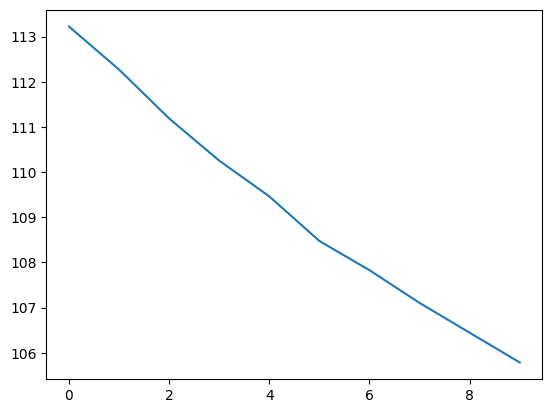

In [121]:
## Plotting the shapelets is easy

plt.plot(torch.tensor(model.shapelets[6][0]))  ## I'll Try to make it match with the timeseries later 

ParameterList(
    (0): Parameter containing: [torch.float32 of size 1x10]
    (1): Parameter containing: [torch.float32 of size 1x10]
    (2): Parameter containing: [torch.float32 of size 1x10]
    (3): Parameter containing: [torch.float32 of size 1x10]
    (4): Parameter containing: [torch.float32 of size 1x10]
    (5): Parameter containing: [torch.float32 of size 1x10]
    (6): Parameter containing: [torch.float32 of size 1x10]
    (7): Parameter containing: [torch.float32 of size 1x10]
    (8): Parameter containing: [torch.float32 of size 1x10]
    (9): Parameter containing: [torch.float32 of size 1x10]
)

tensor([ 80.0944,  79.8535,  81.6252,  85.9091,  92.5682, 101.4552, 111.5973,
        121.8285, 131.0759, 138.5772], grad_fn=<SelectBackward0>)

In [23]:
from utils.DTW import *

tensor(1.2247)


In [28]:
ts1 = torch.tensor([[1.0, 4.5], [2.0, 3.0], [3.0, 4.0]], requires_grad=True)
ts2 = torch.tensor([[1.5, 2.5], [2.5, 3.5], [3.5, 4.5]])

dtw_distance = DTW_calc(ts1, ts2)

# Compute gradients
dtw_distance.backward()

print("DTW Distance:", dtw_distance.item())
print("Gradient for ts1:", ts1.grad)

DTW Distance: 2.291287899017334
Gradient for ts1: tensor([[-0.2182,  0.8729],
        [-0.2182, -0.2182],
        [-0.2182, -0.2182]])
